# Compare Handwritten Signatures using VGG19 and Cosine Similarity

In [1]:
import os
import matplotlib.pyplot as plt
from progressbar import progressbar
import warnings
warnings.filterwarnings('ignore')

def show(img, figsize=(5,5)):
    plt.figure(figsize=figsize)
    plt.imshow(img)
    plt.show()

In [2]:
from keras.preprocessing import image
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input

import numpy as np
import pandas as pd
from scipy.spatial.distance import cosine

Using TensorFlow backend.


In [3]:
model = VGG19(weights='imagenet', include_top=False)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

## Some sample prediction

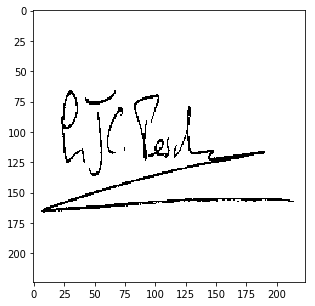

(25088,)


In [4]:
img_path = 'handwritten-signatures/sample_Signature/genuine/NFI-00102001.png'
img = image.load_img(img_path, target_size=(224, 224))
img_data = image.img_to_array(img)
img_data = np.expand_dims(img_data, axis=0)
img_data = preprocess_input(img_data)

vgg16_feature = model.predict(img_data)

show(img)
print(vgg16_feature.flatten().shape)

## Predict for all images
sotore all image features

In [5]:
# define path
path = 'handwritten-signatures/sample_Signature/data'

# define input filenames
filenames = os.listdir(f'{path}/')

sig = dict()
for fname in progressbar(filenames):
    try:
        img = image.load_img(f'{path}/{fname}', target_size=(224, 224))
        img_data = image.img_to_array(img)
        img_data = np.expand_dims(img_data, axis=0)
        sig[fname] = [np.array(model.predict(img_data)).flatten()]
    except: 
        filenames.remove(fname)
        continue
        
sig_df = pd.DataFrame(sig).T
sig_df.head()

100% (300 of 300) |######################| Elapsed Time: 0:00:07 Time:  0:00:07


,0
NFI-02901029.PNG,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
NFI-00101030.PNG,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
NFI-01202021.png,"[0.0, 0.0, 0.0, 0.0, 16.138338, 0.0, 0.0, 0.0,..."
NFI-01702017.png,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
NFI-00403007.png,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


## Min Sample
run this cell to generate some sample

In [49]:
''' predefined sample '''
a  = 'NFI-00101001.png'
b  = 'NFI-00102001.png'

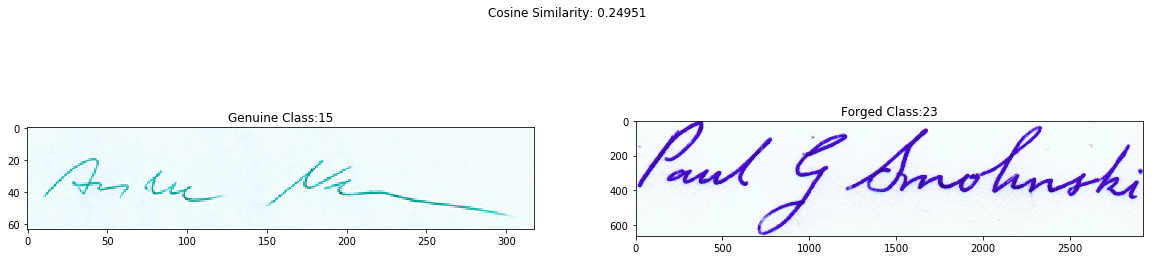

In [133]:
''' random sample '''
sample = sig_df.sample(2)
a,b = sample.index[0], sample.index[1]

'''Comparing'''
sim = np.around(1.0 - cosine(sig_df.T[a][0], sig_df.T[b][0]), 5)
a_author, b_author = int(a.strip('.png').strip('.PNG')[3:6]), int(b.strip('.png').strip('.PNG')[3:6])
a_class, b_class = int(a.strip('.png').strip('.PNG')[-3:]), int(b.strip('.png').strip('.PNG')[-3:])
a_type = 'Genuine' if a_author == a_class else 'Forged'
b_type = 'Genuine' if b_author == b_class else 'Forged'

'''Ploting'''
plt.figure(figsize=(20,5))
plt.suptitle(f'Cosine Similarity: {sim}')
plt.subplot(1,2,1)
plt.title(f"{a_type} Class:{a_class}")
plt.imshow(image.load_img(f'{path}/{a}'))
plt.subplot(1,2,2)
plt.title(f"{b_type} Class:{b_class}")
plt.imshow(image.load_img(f'{path}/{b}'))
plt.show()

## Find Optimal Treshhold

In [7]:
from math import factorial as fat
n = len(sig_df.index)
nof_combination = lambda n,p: fat(n)/(fat(n-p)*fat(p))
nof_combination(n,2)

44850.0

In [8]:
from itertools import combinations
comb =  [i for i in combinations(sig_df.index, 2)]
len(comb)

44850

In [9]:
#dinamic programing for computing all similarities
sims = dict()
for a,b in progressbar(comb):
    not_in_dict = False

    if not(a in sims):
        sims[a] = dict()
    if not(b in sims):
        sims[b] = dict()

    sims[b][a] = dict()
    sims[a][b] = dict()

    sim = 1.0 - cosine(sig_df.T[a][0], sig_df.T[b][0])
    sims[b][a]['dist'] = sim
    sims[a][b]['dist'] = sim

    label = int(a.strip('.png').strip('.PNG')[3:6]) == int(b.strip('.png').strip('.PNG')[3:6]) and int(a.strip('.png').strip('.PNG')[-3:]) == int(b.strip('.png').strip('.PNG')[-3:])
    sims[b][a]['label'] = label
    sims[a][b]['label'] = label

100% (44850 of 44850) |##################| Elapsed Time: 0:00:18 Time:  0:00:18


In [81]:
x = list()
y = list()
for thresh in progressbar(np.linspace(0,1, 100)):
    x.append(thresh)
    y.append(0)
    for a,b in comb:
        predicted = sims[a][b]['dist'] > thresh
        y[-1] += 1 if predicted != sims[a][b]['label'] else 0

optimal_threshhold = np.around(x[y.index(min(y))], 2) # optimall threshhold == where loss is minimum 

x = np.array(x)
y = 1 - np.array(y) / len(comb) # loss => accuracy

minimum_loss = np.around(max(y), 4) # minimaumloss represents the maxmum accuracy

100% (100 of 100) |######################| Elapsed Time: 0:00:04 Time:  0:00:04


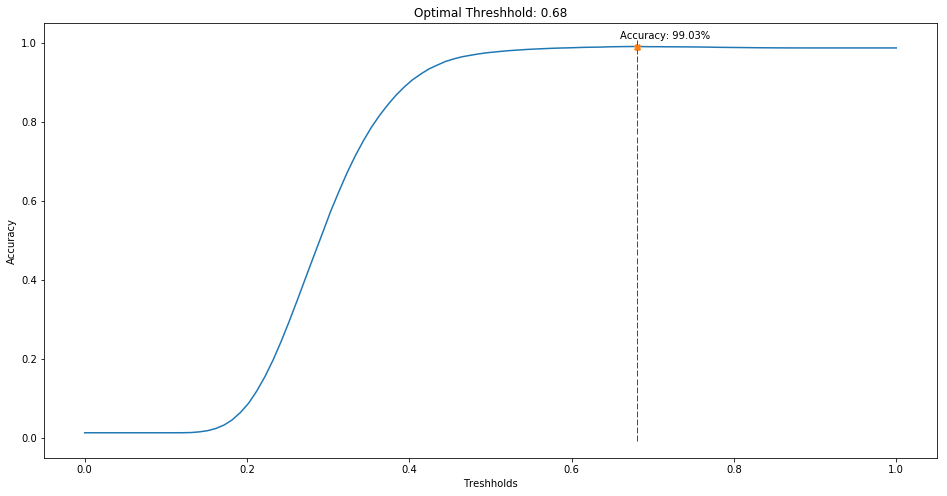

In [134]:
plt.figure(figsize=(16,8))
plt.title(f'Optimal Threshhold: {optimal_threshhold}')

plt.plot(x,y)
plt.plot([optimal_threshhold]*50, np.linspace(0,1), '|g')
plt.plot(optimal_threshhold, minimum_loss, 'X', )
plt.annotate(f'Accuracy: {minimum_loss*100}%', xy=(optimal_threshhold, minimum_loss), xytext=(optimal_threshhold-0.02, 1.01))

plt.xlabel('Treshholds')
plt.ylabel('Accuracy')
plt.show()

## Final Sample

In [70]:
''' predefined sample '''
a  = 'NFI-00101001.png'
b  = 'NFI-00102001.png'

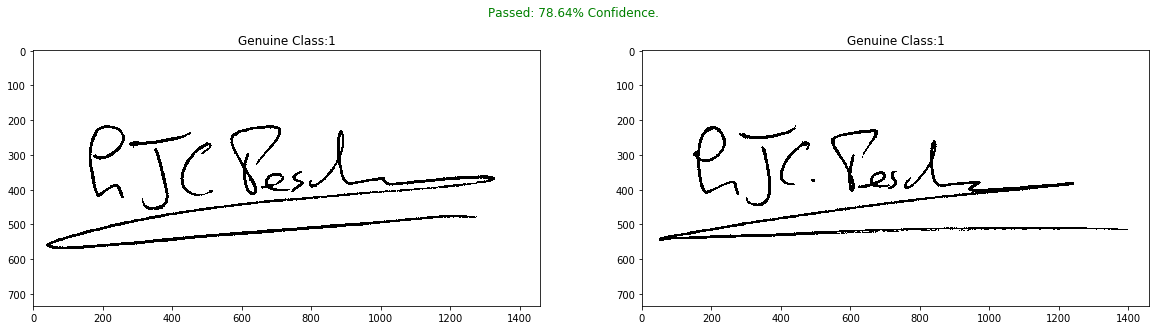

In [71]:
# ''' random sample '''
# sample = sig_df.sample(2)
# a,b = sample.index[0], sample.index[1]

'''Comparing'''
sim = sims[a][b]['dist']
passed = sim>optimal_threshhold
a_author, b_author = int(a.strip('.png').strip('.PNG')[3:6]), int(b.strip('.png').strip('.PNG')[3:6])
a_class, b_class = int(a.strip('.png').strip('.PNG')[-3:]), int(b.strip('.png').strip('.PNG')[-3:])
a_type = 'Genuine' if a_author == a_class else 'Forged'
b_type = 'Genuine' if b_author == b_class else 'Forged'

'''Ploting'''
plt.figure(figsize=(20,5))
plt.suptitle(f'{"Passed" if passed else "Not Passed"}: {np.around(sim*100, 2)}% Confidence.', color=f'{"g" if passed else "r"}')
plt.subplot(1,2,1)
plt.title(f"{a_type} Class:{a_class}")
plt.imshow(image.load_img(f'{path}/{a}'))
plt.subplot(1,2,2)
plt.title(f"{b_type} Class:{b_class}")
plt.imshow(image.load_img(f'{path}/{b}'))
plt.show()